## **Business Understanding :**

- Permettre aux utilisateurs d’afficher les critiques semblable à une critique en cours de lecture

- Améliorer l'experience utilisateur

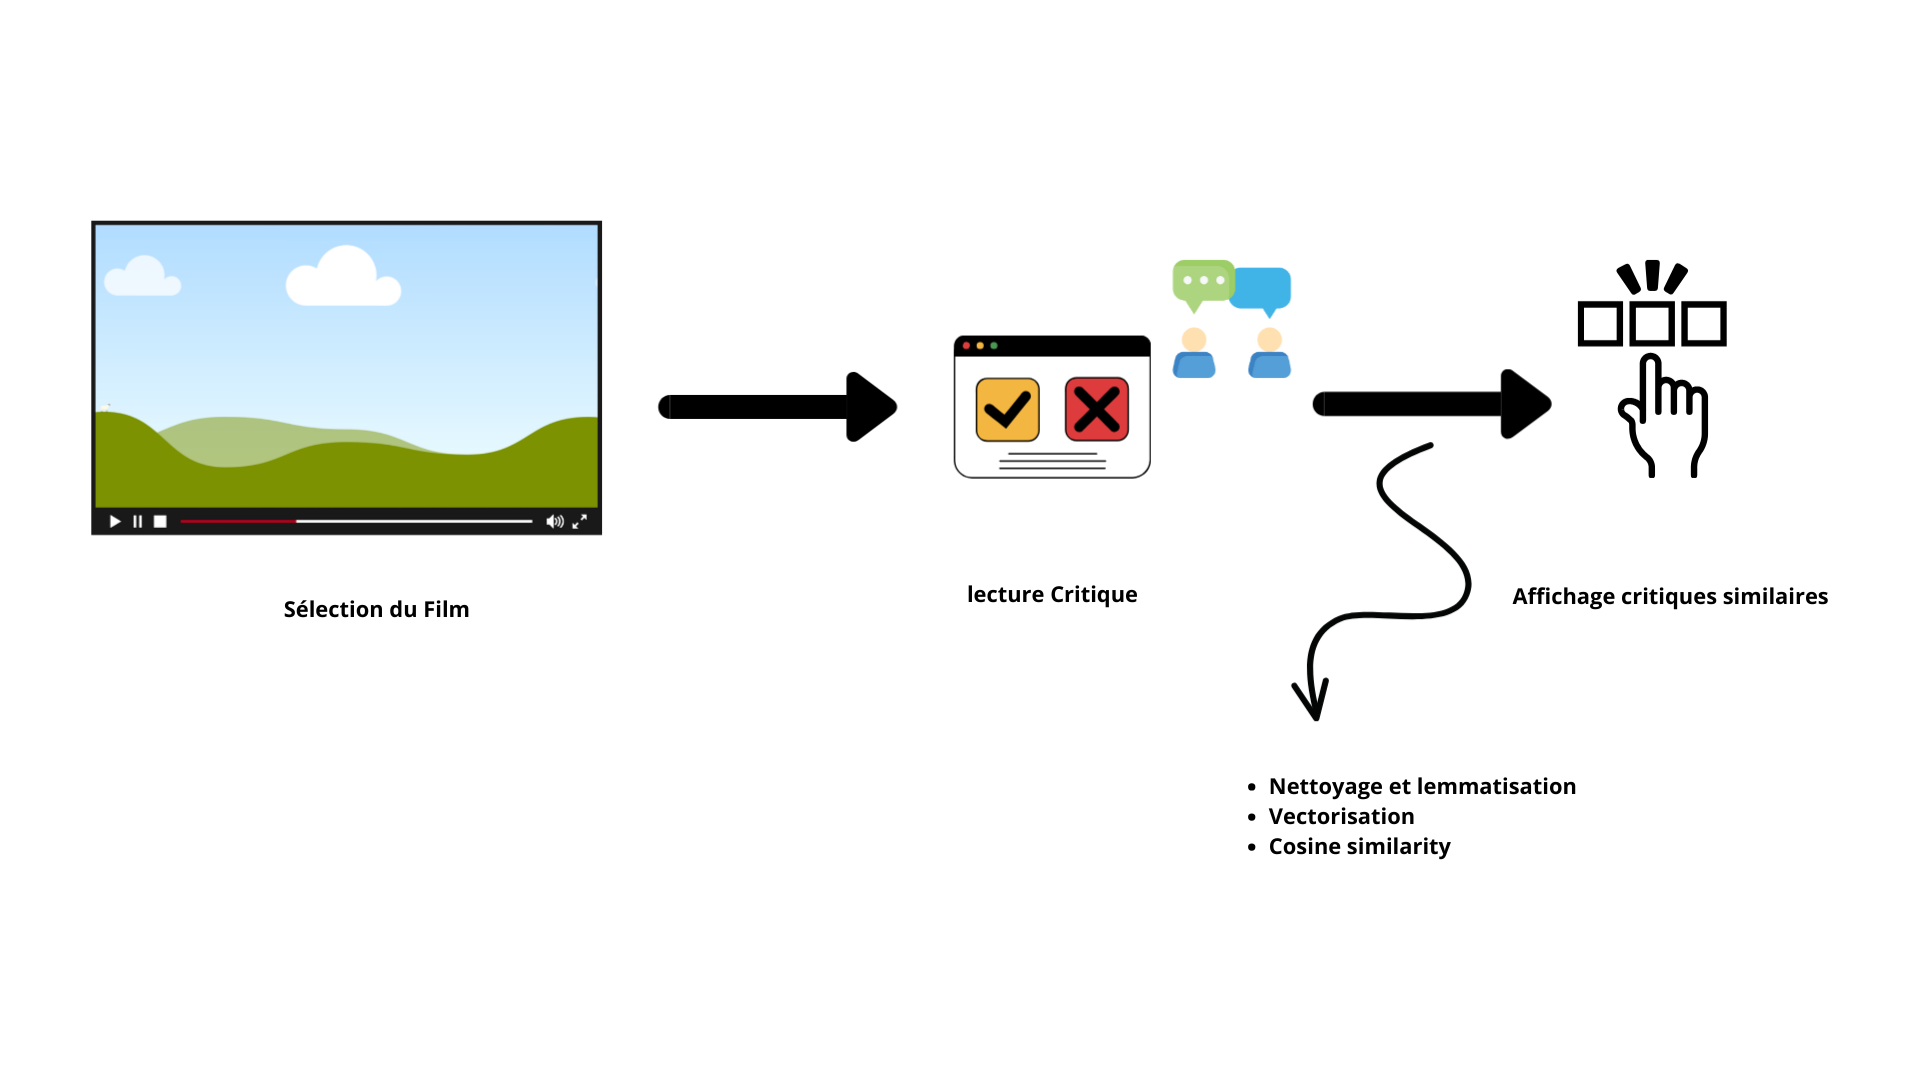

## **Data Understanding :**

- 2 extraits de datasets avec les memes colonnes

- Dataset en français


In [1]:
# liste imports
import pandas as pd
import re
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import vstack



In [2]:
# Chargement des fichiers
df_interstellar = pd.read_csv(
    "interstellar_critiques.csv",
    encoding='utf-8',
    quotechar='"',
    dtype=str # Lire toutes les colonnes comme texte
)

df_fightclub = pd.read_csv(
    "fightclub_critiques.csv",
    encoding='utf-8',
    quotechar='"',
    dtype=str
)


# Nettoyer les retours à la ligne dans review_content pour avoir une dataset plus clair
df_interstellar['review_content'] = df_interstellar['review_content'].str.replace('\n', ' ', regex=True)
df_fightclub['review_content'] = df_fightclub['review_content'].str.replace('\n', ' ', regex=True)



In [3]:
# Vérifier les premières lignes
df_interstellar.head()


,id,URL,rating,review_date_creation,review_date_last_update,review_hits,review_content,review_title,gen_review_like_count,username,user_id
0,25246858,https://senscritique.com/film/xxx/critique/252...,10,06/11/14 12:29,06/11/14 12:29,22676,"Aïe Aïe Aïe, nous y voilà, Interstellar, le fi...","All you need is love, love, love, love...",513,Kobayashhi,44916
1,40035436,https://senscritique.com/film/xxx/critique/400...,4,15/11/14 13:13,15/11/14 13:13,20186,"<p>Chers lecteurs, chères lectrices,</p> <p>A...",10 « bonnes » raisons relatives de ne pas aime...,278,Veather,181882
2,39231131,https://senscritique.com/film/xxx/critique/392...,10,28/02/15 10:36,28/02/15 10:36,19215,<p>Malgré ce que j'entends dire ou lis sur le ...,Tous les chemins mènent à l'Homme,347,blig,133793
3,26720711,https://senscritique.com/film/xxx/critique/267...,9,06/11/14 23:30,06/11/14 23:30,19157,"<p>Un grand film, pour moi, c'est un film qui ...",Rage against the dying of the light.,453,Samu-L,41951
4,24990038,https://senscritique.com/film/xxx/critique/249...,5,05/11/14 20:44,05/11/14 20:44,16856,<p>Tout en n'étant absolument pas un admirateu...,Inspacetion,273,Nushku,24046


In [4]:
df_fightclub.head()

,id,URL,rating,review_date_creation,review_date_last_update,review_hits,review_content,review_title,gen_review_like_count,username,user_id
0,20761,https://senscritique.com/film/xxx/critique/20761,10,12/03/10 00:00,12/03/10 00:00,35817,Fight Club sort à la fin 1999 sur les écrans. ...,Analyse du film et du livre,292,petaire,316
1,30753423,https://senscritique.com/film/xxx/critique/307...,8,28/01/15 09:33,28/01/15 09:33,19867,Tout a été déjà dit sur le film de David Finch...,La consommation identitaire,163,Velvetman,178552
2,12057488,https://senscritique.com/film/xxx/critique/120...,10,19/07/15 02:55,19/07/15 02:55,12672,"<p>Qu'une oeuvre aussi folle, aussi inconforta...",Sons of Anarchy.,199,Gand-Alf,55207
3,10939046,https://senscritique.com/film/xxx/critique/109...,5,05/02/12 14:40,19/08/12 03:33,12669,<p>Beaucoup pensent que ce film n'est qu'un él...,Je suis l'ego démesuré de Jack,191,Ano,2333
4,1966438,https://senscritique.com/film/xxx/critique/196...,9,27/08/14 03:18,27/08/14 03:18,7677,"<p>Objet d’un véritable culte, Fight Club a ma...",Il est temps d'enfreindre les deux premières r...,135,GagReathle,4721


In [5]:
# Réenregistrer les CSV bien formatés
df_interstellar.to_csv("interstellar_bien_formaté.csv", index=True, encoding='utf-8')
df_fightclub.to_csv("fightclub_bien_formaté.csv", index=True, encoding='utf-8')


In [6]:
# avoir une idée sur notre dataset
df_interstellar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       1000 non-null   object
 1   URL                      1000 non-null   object
 2   rating                   1000 non-null   object
 3   review_date_creation     1000 non-null   object
 4   review_date_last_update  1000 non-null   object
 5   review_hits              1000 non-null   object
 6   review_content           1000 non-null   object
 7   review_title             832 non-null    object
 8   gen_review_like_count    1000 non-null   object
 9   username                 1000 non-null   object
 10  user_id                  1000 non-null   object
dtypes: object(11)
memory usage: 86.1+ KB


In [7]:
df_fightclub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       1000 non-null   object
 1   URL                      1000 non-null   object
 2   rating                   1000 non-null   object
 3   review_date_creation     1000 non-null   object
 4   review_date_last_update  1000 non-null   object
 5   review_hits              1000 non-null   object
 6   review_content           999 non-null    object
 7   review_title             649 non-null    object
 8   gen_review_like_count    1000 non-null   object
 9   username                 1000 non-null   object
 10  user_id                  1000 non-null   object
dtypes: object(11)
memory usage: 86.1+ KB


=> Les deux datasets ont 1000 lignes et 11 colonnes de type object qu'on traitera par la suite

## **Data Preprocessing :**

* Nettoyage :

In [8]:
# Vérifier les doublons
print("Doublons Interstellar :", df_interstellar.duplicated().sum())
print("Doublons Fight Club :", df_fightclub.duplicated().sum())

# Supprimer les doublons
df_interstellar = df_interstellar.drop_duplicates()
df_fightclub = df_fightclub.drop_duplicates()


Doublons Interstellar : 0
Doublons Fight Club : 0


In [9]:
# Supprimer les lignes complètement vides
df_interstellar = df_interstellar.dropna(how='all')
df_fightclub = df_fightclub.dropna(how='all')



In [10]:
# Vérifier que les ratings sont bien entre 0 et 10
print(df_interstellar['rating'].unique())
print(df_fightclub['rating'].unique())



['10' '4' '9' '5' '8' '7' '1' '6' '3' '2']
['10' '8' '5' '9' '6' '3' '4' '1' '7' '2']


In [11]:
# Colonnes numériques à convertir
num_cols = ['rating', 'review_hits', 'gen_review_like_count']

# Conversion en float (ou int si tu préfères) et gérer les erreurs
for col in num_cols:
    df_interstellar[col] = pd.to_numeric(df_interstellar[col], errors='coerce')
    df_fightclub[col] = pd.to_numeric(df_fightclub[col], errors='coerce')

# Vérifier les valeurs nulles après conversion
print("Interstellar : valeurs nulles dans colonnes numériques")
print(df_interstellar[num_cols].isnull().sum())
print("\nFight Club : valeurs nulles dans colonnes numériques")
print(df_fightclub[num_cols].isnull().sum())


Interstellar : valeurs nulles dans colonnes numériques
rating                   0
review_hits              0
gen_review_like_count    0
dtype: int64

Fight Club : valeurs nulles dans colonnes numériques
rating                   0
review_hits              0
gen_review_like_count    0
dtype: int64


In [12]:
# Fonction pour détecter si des caractères spéciaux restent
def check_special_chars(df):
    special_chars = ['\n', '\r', '\t']
    for col in df.columns:
        if df[col].dtype == object:  # uniquement les colonnes texte
            for char in special_chars:
                if df[col].str.contains(char).any():
                    print(f"Attention : '{char}' trouvé dans la colonne '{col}'")

# Vérifier pour Interstellar et Fight Club
check_special_chars(df_interstellar)
check_special_chars(df_fightclub)


Attention : '	' trouvé dans la colonne 'review_content'
' trouvé dans la colonne 'review_content'
Attention : '	' trouvé dans la colonne 'review_content'
Attention : '
' trouvé dans la colonne 'review_title'


In [13]:
def clean_general_complete(df):
    for col in df.columns:
        if df[col].dtype == object:  # uniquement colonnes texte
            # Remplacer retours à la ligne, tabulations, retours chariot
            df[col] = df[col].apply(lambda x: x.replace('\n', ' ')
                                             .replace('\r', ' ')
                                             .replace('\t', ' ')
                                             .replace("'", "") if isinstance(x, str) else x)
            # Supprimer espaces multiples
            df[col] = df[col].apply(lambda x: re.sub(' +', ' ', x) if isinstance(x, str) else x)
    # Supprimer lignes complètement vides
    df = df.dropna(how='all')
    return df

# Appliquer aux deux CSV
df_interstellar = clean_general_complete(df_interstellar)
df_fightclub = clean_general_complete(df_fightclub)

# Vérifier à nouveau les caractères spéciaux
check_special_chars(df_interstellar)
check_special_chars(df_fightclub)


On s'interesse par la suite au review_content:

- NLTK / spaCy : prétraitement des textes, stopwords, lemmatisation et tokenization.

In [14]:
# # Charger stopwords français et modèle SpaCy français
# nltk.download('stopwords')
french_stopwords = set(stopwords.words('french'))

# # Charger le modèle SpaCy français
# !python -m spacy download fr_core_news_sm
nlp = spacy.load("fr_core_news_sm")  # modèle français pour le traitement NLP

In [16]:
# Vérifier les valeurs manquantes
print("Interstellar - review_content_clean NaN :", df_interstellar['review_content'].isnull().sum())
print("Fight Club - review_content_clean NaN :", df_fightclub['review_content'].isnull().sum())


Interstellar - review_content_clean NaN : 0
Fight Club - review_content_clean NaN : 1


On utilise :

- Stopwords : mots courants ignorés car peu informatifs.

- Lemmatisation : transformer les mots en leur forme de base.

In [17]:
def clean_and_lemmatize(text):
    if not text or not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zàâäéèêëïîôöùûüç0-9\s]', ' ', text)  # garder lettres françaises + chiffres
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    cleaned_text = " ".join(tokens)
    # Supprimer espaces multiples
    cleaned_text = re.sub(' +', ' ', cleaned_text).strip()
    return cleaned_text


df_interstellar['review_content_clean'] = df_interstellar['review_content'].apply(clean_and_lemmatize)
df_fightclub['review_content_clean'] = df_fightclub['review_content'].apply(clean_and_lemmatize)




TF-IDF : vectorisation des critiques pour le calcul de similarité.

In [18]:
# TF-IDF
vectorizer_inter = TfidfVectorizer(stop_words=list(french_stopwords))
tfidf_matrix_inter = vectorizer_inter.fit_transform(df_interstellar['review_content_clean'])

vectorizer_fight = TfidfVectorizer(stop_words=list(french_stopwords))
tfidf_matrix_fight = vectorizer_fight.fit_transform(df_fightclub['review_content_clean'])


Similarité cosinus : mesure la ressemblance entre deux textes en comparant l’orientation de leurs vecteurs.

In [19]:
# Similarité cosinus
cosine_sim_inter = cosine_similarity(tfidf_matrix_inter, tfidf_matrix_inter)
cosine_sim_fight = cosine_similarity(tfidf_matrix_fight, tfidf_matrix_fight)


In [20]:
def recommend_reviews(df, cosine_sim, top_n=5):
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # exclure la critique elle-même
    review_indices = [i[0] for i in sim_scores]
    return df.iloc[review_indices][[ 'review_content']]

# Exemple pour Interstellar
review_index = 0
cosine_sim_first_review = cosine_similarity(
    tfidf_matrix_inter[review_index], tfidf_matrix_inter
).flatten()

print("Recommandations Interstellar pour la première critique :")
print(recommend_reviews(df_interstellar, cosine_sim_first_review))

# Exemple pour Fight Club
cosine_sim_first_fight = cosine_similarity(
    tfidf_matrix_fight[0], tfidf_matrix_fight
).flatten()

print("\nRecommandations Fight Club pour la première critique :")
print(recommend_reviews(df_fightclub, cosine_sim_first_fight))


Recommandations Interstellar pour la première critique :
                                        review_content
69   Il faut croire quavant dêtre un film de scienc...
438  <p>Etant un grand passionné de science fiction...
713  En quelques films, Nolan a réussit à simposer ...
169  Cest presque devenu une tradition, tous les an...
108  INTERSTELLAR de Christopher Nolan. Voilà un fi...

Recommandations Fight Club pour la première critique :
                                        review_content
16   David Fincher et son grand duo dacteurs (Brad ...
366  <p>Un film trop parfait, chargé doriginalité. ...
919  <p><em>Fight Club</em> est un film produit par...
870  <p>First, we must all agree that Fincher was s...
244  Fight Club est un film très bon avec plusieurs...


In [21]:
# --- Nouvelle critique ---
new_review_inter = "Interstellar est incroyable, les voyages spatiaux et les émotions sont très bien rendus."
new_review_fight = "Fight Club est trop violent à mon goût, je n'ai pas aimé les combats à mains nues."

# --- Interstellar ---
new_vec_inter = vectorizer_inter.transform([new_review_inter])
tfidf_matrix_inter_extended = vstack([tfidf_matrix_inter, new_vec_inter])
cosine_sim_inter_extended = cosine_similarity(new_vec_inter, tfidf_matrix_inter_extended).flatten()

print("Recommandations Interstellar pour la nouvelle critique :")
print(recommend_reviews(
    df_interstellar,
    cosine_sim_inter_extended
))

# --- Fight Club ---
new_vec_fight = vectorizer_fight.transform([new_review_fight])
tfidf_matrix_fight_extended = vstack([tfidf_matrix_fight, new_vec_fight])
cosine_sim_fight_extended = cosine_similarity(new_vec_fight, tfidf_matrix_fight_extended).flatten()

print("\nRecommandations Fight Club pour la nouvelle critique :")
print(recommend_reviews(
    df_fightclub,
    cosine_sim_fight_extended
))


Recommandations Interstellar pour la nouvelle critique :
                                        review_content
355  <p>Incroyable, le nouveau film très attendu de...
686  Ce film nous fait rêver en nous emmenant au lo...
166  <p>Est-ce que je suis un fanboy hardcore incap...
751  Interstellar est ce que l’on peut appeler un f...
971  <p>Chef dœuvre de cette année 2014, Nolan prop...

Recommandations Fight Club pour la nouvelle critique :
                                        review_content
714  <p>De base, tas déjà vu ce film et tu las aimé...
331  Fight Club me possède, je suis Fight Club, jai...
222  "La première règle du fight club est : il est ...
551  La première règle du Fight Club est : il est i...
880  <p>Un scénario au top , avec des scènes assez ...


## **Perspectives :**


- Utilisation de modèles d’embeddings plus avancés pour améliorer la précision des similarités.

- Incorporation du titre de la critique pour enrichir la représentation textuelle.

- Ajout d’un filtrage par sentiment (positif/négatif) pour proposer des recommandations plus pertinentes.

- Déploiement du moteur de recommandation en ligne via Flask.
